In [2]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import random
import joblib
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd

2021-11-19 22:18:52.059910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-19 22:18:52.059948: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed'
    }
TSS_HK = []

with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1','2','3']:
            TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))

TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))

bamfile = ps.AlignmentFile(dic['bam123'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000

In [4]:
cc = []
ll = []
ee = []
ww = []
win = 40
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    # cc.append(cov)
    # ll.append(long-short)
    # ee.append(up_end-down_end)
    # ww.append(wps)
    ins = [np.mean(cov),np.mean(long-short),np.mean(up_end-down_end),np.mean(wps)]
    feature_matrix.append(ins)
feature_matrix = np.array(feature_matrix)

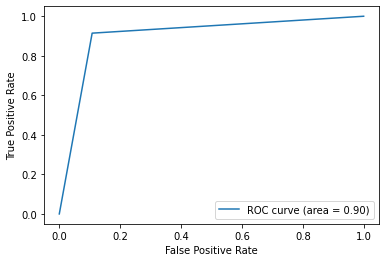

In [7]:
train_x = feature_matrix[:int(len(feature_matrix)*0.8)]
train_y = labels[:int(len(labels)*0.8)]
test_x = feature_matrix[int(len(feature_matrix)*0.8):]
test_y = labels[int(len(labels)*0.8):]
rfClf = RandomForestClassifier(n_estimators=400,criterion='gini')
rfClf.fit(train_x, train_y)
pred_rf = rfClf.predict(test_x)
# num = len(pred_rf)
# accuracy_rf = len([1 for i in range(num) if test_y[i] == pred_rf[i]]) / float(num)
# print("rf,acc:",accuracy_rf)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_rf, pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


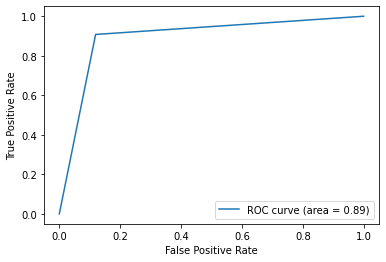

In [9]:
svcClf = SVC(C=1.0, kernel='rbf')
svcClf.fit(train_x,train_y)
pred_svm = svcClf.predict(test_x)
# num = len(pred_svm)
# accuracy_svm = len([1 for i in range(num) if test_y[i] == pred_svm[i]]) / float(num)
# print("svm,acc:",accuracy_svm)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_svm, pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()